<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/modern_approach/text_to_image/imagen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imagen

In [ ]:
!pip install -q imagen-pytorch

In [17]:
import torch
from imagen_pytorch import Unet, Imagen
import numpy as np
from PIL import Image

In [ ]:
unet1 = Unet(
    dim = 32,
    cond_dim = 512,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = 3,
    layer_attns = (False, True, True, True),
    layer_cross_attns = (False, True, True, True)
)

unet2 = Unet(
    dim = 32,
    cond_dim = 512,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = (2, 4, 8, 8),
    layer_attns = (False, False, False, True),
    layer_cross_attns = (False, False, False, True)
)

imagen = Imagen(
    unets = (unet1, unet2),
    image_sizes = (64, 256),
    beta_schedules = ('cosine', 'linear'),
    timesteps = 1000,
    cond_drop_prob = 0.1
).cuda()

text_embeds = torch.randn(4, 256, 768).cuda()
text_masks = torch.ones(4, 256).bool().cuda()
images = torch.randn(4, 3, 256, 256).cuda()

for _ in range(20):
    for i in (1, 2):
        loss = imagen(images, text_embeds = text_embeds, text_masks = text_masks, unet_number = i)
        loss.backward()

images = imagen.sample(texts = [
    'a whale breaching from afar',
    'young girl blowing out candles on her birthday cake',
    'fireworks with blue and green sparkles'
], cond_scale = 2.)

images.shape  # (3, 3, 256, 256)

In [ ]:
from google.colab.patches import cv2_imshow

img = np.array(images[0].cpu() * 255, dtype=np.uint8)
img

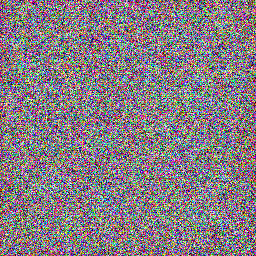

In [69]:
cv2_imshow(img.T)